# Data preprocessing

How will you tokenize the data set? What will consist of a singular sequence, a poem, a stanza, or a line? Do you keep some words tokenized as bigrams? Do you split hyphenated words? How will you handle punctuation? 

Tokenize words in sonnet
Keep apostrophes and hyphens in a given word and remove other punctuation

Map words to a unique ID in a dictionary. Then map unique ID to number of syllables another dictionary.

Get syllables.

In [1]:
import itertools
import nltk
from nltk.corpus import cmudict
nltk.download('cmudict')
import pickle
import networkx 
from networkx.algorithms.components.connected import connected_components
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Error loading cmudict: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:749)>


In [2]:
def clean_up_quotes(word):
    exception_words = ["'this", "'thou", "'had", "'thus", "'truth", "'now", "'will", "will'", "'will'", "'i", "'not"
                       , "hate'", "none'", "love'", "you'", "excuse'", "intermixed'", "best'", "friend'"]
    
    if word in exception_words:
        word = word.strip('\'')
    return word
    

In [3]:
def get_sonnets(filename):
    """ Returns list of separate sonnets in the file. 
    Each line of a sonnet is a list of words (tokens). """
    with open(filename) as file:
        sons, son = [], []
        for line in file:
            line = line.strip()
            if line.isdigit() == False:
                lst = line.lower().translate(str.maketrans('', '', ':;,.?!()')).split()
                cleaned_list = []
                
                for word in lst:
                    cleaned_list.append(clean_up_quotes(word))
                
                lst = cleaned_list    
                if len(lst) > 0: # count words in line
                    son.append(lst)
                elif len(son) > 0:
                    sons.append(son)
                    son = []
    sons.append(son) # add the final sonnet
    return sons

In [4]:
file = 'data/shakespeare.txt'
sonnets = get_sonnets(file)

# The sonnets 99 and 126 (at indices 98 and 125)
# do not count as sonnets, since they are not 14 lines long
for i in range(len(sonnets)):
    if len(sonnets[i]) != 14:
        print(i)
        
sonnets = sonnets[:98] + sonnets[99:125] + sonnets[126:]

with open('data/sonnets.pkl', 'wb') as f:
    pickle.dump(sonnets, f)
    

98
125


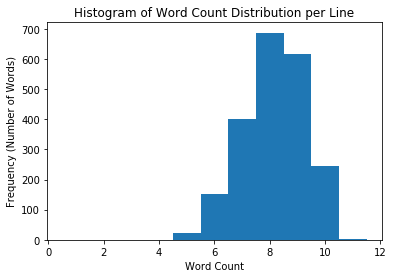

In [5]:
# plot word count distribution per line
lines = list(itertools.chain.from_iterable(sonnets))
word_count = [len(line) for line in lines]

_ = plt.hist(word_count, bins=np.arange(0.5, 12.5, 1))
_ = plt.title('Histogram of Word Count Distribution per Line')
_ = plt.xlabel('Word Count')
_ = plt.ylabel('Frequency (Number of Words)')
plt.savefig('visuals/word_count.png')
_ = plt.show()

In [6]:
def get_id(lines):
    """ Returns dictionary of words to IDs and 
    dictionary of IDs to words. """
    dic_to_ids, dic_to_words = {}, {}
    id_ = 0
    
    for line in lines:
        for word in line:
            word = clean_up_quotes(word)
            if word not in dic_to_ids:
                dic_to_ids[word] = id_
                dic_to_words[id_] = word
                id_ += 1
    return dic_to_ids, dic_to_words

In [7]:
def get_mappings(sonnets, name):
    """ Returns dictionary of words to IDs, dictionary of IDs to words, 
    and dictionary of IDs to syllables. """    
    lines = list(itertools.chain.from_iterable(sonnets)) # list of lines
    dic_to_ids, ids_to_dic = get_id(lines)
    
    # take first thing that is int thing in txt
    dic_to_syl = {}
    with open("data/Syllable_dictionary.txt", "r") as f:
        for line in f:
            temp = line.strip().split(" ")
            word = temp[0]
            word = clean_up_quotes(word)
            count = temp[1:]

            for possible_val in count:
                if possible_val.isdigit():
                    dic_to_syl[word] = int(possible_val)
                    break
    
    for word in dic_to_ids:
        if word not in dic_to_syl:
            dic_to_syl[word] = dic_to_syl[word.strip("\'")]
    
    syl_to_dic = {}
    
    for word in dic_to_syl:
        syl_count = 
    syl_to_dic = {v: k for k,v in dic_to_syl.items()}
    
    with open(name, 'wb') as f:
        pickle.dump((dic_to_ids, dic_to_syl, ids_to_dic, syl_to_dic), f)
    
    return dic_to_ids, dic_to_syl, ids_to_dic, syl_to_dic

In [8]:
dic_to_ids, dic_to_syl, ids_to_dic, syl_to_dic = get_mappings(sonnets, 'data/shakespeare_dics.pkl')

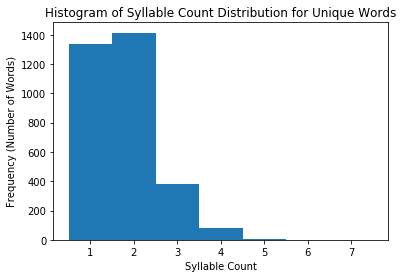

In [9]:
_ = plt.hist(list(dic_to_syl.values()), bins=np.arange(0.5, 8.5, 1))
_ = plt.title('Histogram of Syllable Count Distribution for Unique Words')
_ = plt.xlabel('Syllable Count')
_ = plt.ylabel('Frequency (Number of Words)')
plt.savefig('visuals/syllables.png')
_ = plt.show()

# Additional Goals: Rhymes

In [10]:
def get_rhymes(sonnets):
    """ Returns list of pairs of rhyming words in each sonnet. """
    rhyme = []
    last_words = [] # compile all last words
    for son in sonnets:
        lst = [] # store list of last words in each line
        for line in son:
            lst.append(line[-1])
        last_words.append(lst)
    
    # get pairs of rhyming words
    for son in last_words:
        for i in [0, 1, 4, 5, 8, 9]:
            rhyme.append([son[i], son[i + 2]])
        rhyme.append([son[12], son[13]])
    
    # remove duplicates
    rhyme = [list(set(r)) for r in rhyme]
    return rhyme

In [11]:
def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

def get_all_rhymes(name):
    """ Returns list of lists of rhyming words from sonnets. """
    rhyme = get_rhymes(sonnets)
    G = to_graph(rhyme)
    all_r = connected_components(G)
    all_rhymes = [list(r) for r in all_r]
    
    with open(name, 'wb') as f:
        pickle.dump(all_rhymes, f)

    return all_rhymes

In [12]:
all_r = get_all_rhymes('data/shakespeare_rhymes.pkl')

In [13]:
rhyme_count = [len(r) for r in all_r]

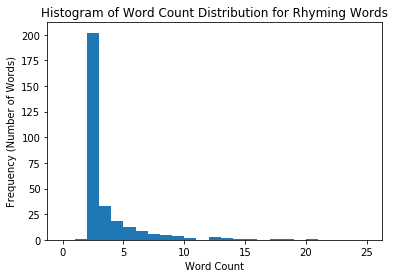

In [14]:
_ = plt.hist(rhyme_count, bins=np.arange(0, 25.5, 1))
_ = plt.title('Histogram of Word Count Distribution for Rhyming Words')
_ = plt.xlabel('Word Count')
_ = plt.ylabel('Frequency (Number of Words)')
plt.savefig('visuals/rhyme_word_count.png')
_ = plt.show()

# Meter

In [15]:
def get_meter(name, lines):
    """ Returns dictionary mapping unstressed/stressed
    syllables to words. """
    meter = {}
    
    for line in lines:
        total_syl = 0
        for word in line:
            word = clean_up_quotes(word)
            syl = -1
            if word in dic_to_syl:
                syl = dic_to_syl[word] # get count of syllables
            else:
                temp_word = word
                syl = dic_to_syl[temp_word.strip('\'')]
            
            stresses = []
            # determine how may unstressed/stressed syllables 
            # there are in the word
            for i in range(syl):
                if (total_syl + i) % 2 == 0: 
                    stresses.append(0)
                else:
                    stresses.append(1)

            stress = ', '.join(str(i) for i in stresses)
            if stress in meter.keys():
                meter[stress].add(word)
            else:
                meter[stress] = set()
                meter[stress].add(word)

            total_syl += syl
            
    with open(name, 'wb') as f:
        pickle.dump(meter, f)
    
    dic_to_meter = {}
    
    for met_val in meter:
        for dic_val in meter[met_val]:
            dic_to_meter[dic_val] = met_val
    
    with open('data/dic_to_meter.pkl', 'wb') as f:
        pickle.dump(dic_to_meter, f)
        
    return meter

In [16]:
lines = []

for sonnet in sonnets:
    for line in sonnet:
        lines.append(line)

meter_to_dic = get_meter('data/meter_to_dic.pkl', lines)